In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import datetime
import glob
from pathlib import Path
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

DOWNLOAD_DIR = '../../entsoe-data/'

This will import the data, you have to run it to be able to solve the homework.

In [3]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(DOWNLOAD_DIR)

Concatenating 68 csv files...
Loading done.


In [4]:
power_demand["AreaName"].unique()


array(['50Hertz CA', 'APG BZ', 'APG CA', 'AST BZ', 'AST CA', 'Albania',
       'Amprion CA', 'Austria', 'Belgium', 'Bosnia Herzegovina',
       'Bulgaria', 'CEPS BZ', 'CEPS CA', 'CGES BZ', 'CGES CA', 'CREOS CA',
       'Croatia', 'Cyprus', 'Cyprus TSO BZ', 'Cyprus TSO CA',
       'Czech Republic', 'DE-AT-LU BZ', 'DE-LU BZ', 'DK1  BZ', 'DK2 BZ',
       'Denmark', 'ELES BZ', 'ELES CA', 'EMS BZ', 'EMS CA', 'ESO BZ',
       'ESO CA', 'EirGrid CA', 'Elering BZ', 'Elering CA', 'Elia BZ',
       'Elia CA', 'Energinet CA', 'Estonia', 'Fingrid BZ', 'Fingrid CA',
       'Finland', 'France', 'Germany', 'Greece', 'HOPS BZ', 'HOPS CA',
       'Hungary', 'IPTO BZ', 'IPTO CA', 'IT-Centre-North BZ',
       'IT-Centre-South BZ', 'IT-North BZ', 'IT-Sardinia BZ',
       'IT-Sicily BZ', 'IT-South BZ', 'Ireland', 'Ireland - (SEM) BZ',
       'Italy', 'Italy CA', 'Latvia', 'Litgrid BZ', 'Litgrid CA',
       'Lithuania', 'Luxembourg', 'MAVIR BZ', 'MAVIR CA', 'MD BZ',
       'MD CA', 'MEPSO BZ', 'MEPSO CA', '

# Exercise 1 - Calculate the relation of Wednesday average consumption to Sunday average consumption for selected countries

In this exercise, calculate the relation of Wednesday average consumption to Sunday average consumption for the following countries: Austria, Germany, United Kingdom, Spain, Sweden, Italy, Croatia.

(1) First create a variable that contains only power consumption data for these countries. The pandas command ```isin()``` may be very helpful here. Reduce the data to only consider the period 2015-01-01 until 2019-12-31. The lecture slides may contain relevant code here.

(2) Then, group the data by weekday and country (i.e. AreaName). Use ```groupby``` and ```mean```for that purpose. 

(3) Calculate for all countries the proportion of Wednesday (day 2) and Sunday (day 6) by dividing the two values.

(4) For which country, this relative value is highest? What could this indicate?

In [6]:
# 1a. filter power_consumption data by countries

list_countries = [
    "Austria",
    "Germany",
    "United Kingdom",
    "Spain",
    "Sweden",
    "Italy",
    "Croatia"
]

filterd_power_demand = power_demand[power_demand["AreaName"].isin(list_countries)]

print(filterd_power_demand.shape)


# 2b. filter for period 2015-01-01 until 2019-12-31
filterd_power_demand = filterd_power_demand['2015-01-01':'2019-12-31']
print(filterd_power_demand.shape) # about 46,000 rows removed

(646181, 10)
(600307, 10)


In [7]:
# 2. group the data by weekday and country

power_demand_weekday_country = filterd_power_demand.groupby([
    filterd_power_demand.index.weekday,
    "AreaName"
]).mean()

power_demand_weekday_country.head(n=5)

Year     Month        Day  TotalLoadValue
DateTime AreaName                                                  
0        Austria   2017.003831  6.521073  15.701149     7400.972206
         Croatia   2017.003831  6.521073  15.701149     2027.824553
         Germany   2017.003792  6.521293  15.701457    57899.311051
         Italy     2017.003831  6.521073  15.701149    34013.568646
         Spain     2017.004792  6.522524  15.699361    29367.402875

In [8]:
# 3. proportion of Wednesday (day 2) and Sunday (day 6) for all countries
power_demand_wed = power_demand_weekday_country.loc[2,["TotalLoadValue"]]
power_demand_sun = power_demand_weekday_country.loc[6,["TotalLoadValue"]] 

power_demand_share = power_demand_wed / power_demand_sun
power_demand_share

,TotalLoadValue
AreaName,
Austria,1.269930
Croatia,1.149882
Germany,1.298468
Italy,1.376237
Spain,1.211247
Sweden,1.117265
United Kingdom,1.133224


In [9]:
# 4a. For which country, this relative value is highest?
power_demand_share[power_demand_share["TotalLoadValue"] == power_demand_share["TotalLoadValue"].max()]

,TotalLoadValue
AreaName,
Italy,1.376237


Result shows that for the selected countries, the difference between power demand on Wednesday and Sunday is largest for Italy. i.e. the power consumption is 1.376 times higher on Wednesdays than on Sundays.

**4b. What could this indicate?**<br />
Maybe Italiens spend Sundays outside and therefore don't need as much energy.

# Exercise 2 - Calculate the monthly average consumption as deviation from mean consumption

For the same countries as in the above dataset, calculate the monthly mean consumption as deviation from the mean of consumption over the whole time. Plot the curves for all countries.

(1) First create a variable that contains only power consumption data for the selected countries. The pandas command ```isin()``` may be very helpful here. If you did Exercise 1, you can use the same dataset.

(2) Then, aggregate the data by country (i.e. AreaName) and month. Use ```groupby``` and ```mean``` for that purpose. Select the column ```TotalLoadValue``` from the result.

(3)  Aggregate the data by country (i..e AreaName) only, i.e. calculate the average consumption by country using ```groupby``` and ```mean```. Select the column ```TotalLoadValue``` from the result.

(4) Divide the result of (2) by (3) and observe how well broadcasting works here.

(5) Use the command ```unstack``` on the result. How does the table look now? Plot the result. If your resulting, unstacked dataframe is called ```result```, you may use ```result.plot()``` to get a nice plot.

(6) How would you explain the difference in the curve between Croatia and Sweden?


DateTime              1         2         3         4         5         6   \
AreaName                                                                     
Austria         1.113425  1.128539  1.063218  0.953912  0.910074  0.926077   
Croatia         1.082719  1.063903  1.001216  0.918810  0.905044  0.958456   
Germany         1.064554  1.074510  1.036265  0.966114  0.948962  0.963211   
Italy           1.026697  1.049985  0.990605  0.910626  0.933483  1.026133   
Spain           1.064727  1.066895  1.001202  0.941515  0.935340  0.995052   
Sweden          1.274837  1.240632  1.139172  0.995361  0.875668  0.820553   
United Kingdom  1.133772  1.158053  1.094719  0.996545  0.948103  0.915583   

DateTime              7         8         9         10        11        12  
AreaName                                                                    
Austria         0.916214  0.905685  0.942456  0.987381  1.075567  1.085772  
Croatia         1.064057  1.052261  0.957277  0.935913  0.991125  

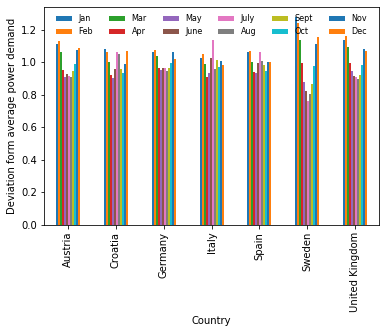

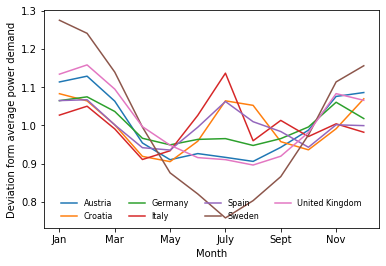

In [12]:
# Power consumption for selected countries
# (variable from exercise one only 2015-01-01 to 2019-12-31)
filterd_power_demand

# 2. group by country and month
power_demand_monthly_country = filterd_power_demand.groupby(["AreaName",filterd_power_demand.index.month]).mean()
# select column TotalLoadValue 
power_demand_monthly_country = power_demand_monthly_country["TotalLoadValue"]

# 3. group by country
power_demand_country = filterd_power_demand.groupby("AreaName").mean()
power_demand_country = power_demand_country["TotalLoadValue"]

# 4. divide 2. by 3. 
power_demand_monthly_deviation = power_demand_monthly_country / power_demand_country

# 5. unstack the table
power_demand_unstacked = power_demand_monthly_deviation.unstack()
# unstack pivots a table -> table now has a column with deviation from average for each month and a row for each selected country
print(power_demand_unstacked)


power_demand_unstacked.columns.name = "Month"
power_demand_unstacked.index.name = "Country"
power_demand_unstacked.columns = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "June",
    "July",
    "Aug",
    "Sept",
    "Oct",
    "Nov",
    "Dec"
    ]


p1 = power_demand_unstacked.plot(
    kind = "bar"
)
plt.xlabel("Country")
plt.ylabel("Deviation form average power demand")
plt.legend(
    frameon=False,
    loc='upper center',
    ncol=6,
    fontsize=8
    )

# Isn't it nicer that way?
p2 = power_demand_unstacked.T.plot()
plt.xlabel("Month")
plt.ylabel("Deviation form average power demand")
#p2.set_xlabel("Country")
#p2.set_ylabel("Deviation form average power demand")
plt.legend(
    frameon=False,
    loc='lower center',
    ncol=4,
    fontsize=8
    )

**6. Difference in power demand between Sweden and Croatia** <br />
The strong fluctuation in power demand in Sweden might be caused by the mightnight sun (less light/energy demand) and winter darkness + colder winters (-> higher energy demand for light and heating) than in Croatia. Whereas, in Croatia power demand increases in summer, which might be caused by the air-conditioning systems and the high number of tourists in summer.

# Exercise 3 - calculate the hourly average consumption as deviation from mean consumption

Do the same as in exercise 2, but now for the hourly average consumption. I.e. how much is consumed on each of the 24 hours of a day?

Which country has the lowest, which the highest variability? What may be the reason for it?

DateTime                  0             1             2             3   \
AreaName                                                                 
Austria          5655.575192   5523.785159   5518.822946   5825.381928   
Croatia          1500.185104   1454.035597   1451.239869   1490.543264   
Germany         44154.977134  43816.552422  44398.529814  46219.754918   
Italy           24837.571194  24190.425520  24083.920591  24642.732202   
Spain           23931.919496  23121.884320  22752.728916  22805.071233   
Sweden          13344.217224  13279.558114  13292.226425  13575.332237   
United Kingdom  28138.366860  27268.994525  26235.764027  25655.585531   

DateTime                  4             5             6             7   \
AreaName                                                                 
Austria          6505.153560   7265.413143   7795.908762   7987.890416   
Croatia          1662.369113   1910.456736   2078.748631   2186.358708   
Germany         50436.618469  55414.5

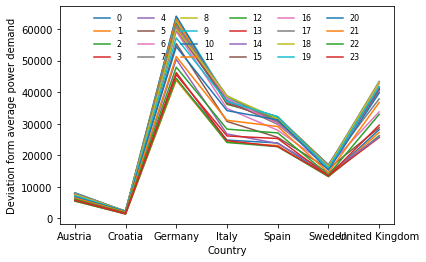

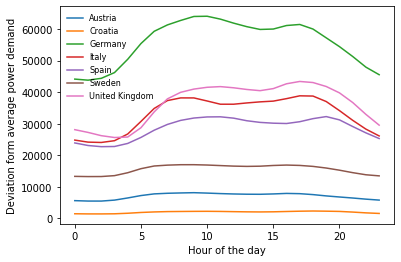

In [13]:
# Power consumption for selected countries
# (variable from exercise one only 2015-01-01 to 2019-12-31)
filterd_power_demand

# 2. group by country and month
power_demand_hourly_country = filterd_power_demand.groupby(["AreaName",filterd_power_demand.index.hour]).mean()
# select column TotalLoadValue 
power_demand_hourly_country = power_demand_hourly_country["TotalLoadValue"]

# 3. group by country (from exercise above)
#power_demand_country = filterd_power_demand.groupby("AreaName").mean()
#power_demand_country = power_demand_country["TotalLoadValue"]
power_demand_country

# 4. divide 2. by 3. 
power_demand_hourly_deviation = power_demand_hourly_country / power_demand_country

power_demand_unstacked_hr = power_demand_hourly_country.unstack()
# unstack pivots a table -> table now has a column with deviation from average for each month and a row for each selected country
print(power_demand_unstacked_hr)


power_demand_unstacked_hr.columns.name = "Hour"
power_demand_unstacked_hr.index.name = "Country"

p1 = power_demand_unstacked_hr.plot()
plt.xlabel("Country")
plt.ylabel("Deviation form average power demand")
plt.legend(
    frameon=False,
    loc='upper center',
    ncol=6,
    fontsize=8
    )

p2 = power_demand_unstacked_hr.T.plot()
plt.xlabel("Hour of the day")
plt.ylabel("Deviation form average power demand")
#p2.set_xlabel("Country")
#p2.set_ylabel("Deviation form average power demand")
plt.legend(
    frameon=False,
    loc='upper left',
    ncol=1,
    fontsize=8
    )

The plots show, that Germany has the highest fluctuations in daily power demand, followed by Italy, the UK, and Spain. In Germany power demand is highest in the morning between 6.00 am and 9.00 am when people get up/go to work and again between 4.00 pm and 7.00 pm, when people come home from work.

# Exercise 4 - Calculate the average load per capita

Below you find a table with population data for our selected countries. You should use it to calculate per capita consumption.

(1) Calculate the average load in all countries using ```groupby``` and ```mean``` and select the column ```TotalLoadValue``` from the result.

(2) Divide the result by the ```Population``` column of the dataframe ```population```. Observe, how broadcasting helps here nicely.

(3) Plot the result. Which country has the highest load, which the lowest? What may be the reason? In which unit is this value? How could we convert it to MWh per year?

In [212]:
population = pd.DataFrame({'Country': ["Austria", "Croatia", "Germany", "Italy", "Spain", "Sweden", "United Kingdom"],
             'Population': [8840521, 4087843, 82905782, 60421760, 46796540, 10175214, 66460344]})

population.index = population["Country"]

population

,Country,Population
Country,,
Austria,Austria,8840521
Croatia,Croatia,4087843
Germany,Germany,82905782
Italy,Italy,60421760
Spain,Spain,46796540
Sweden,Sweden,10175214
United Kingdom,United Kingdom,66460344


<Figure size 432x288 with 0 Axes>

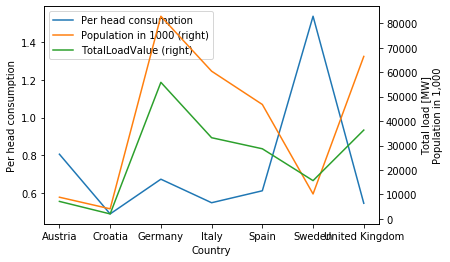

In [312]:
# average load per country (from exercise above)
#power_demand_country = filterd_power_demand.groupby("AreaName").mean()
#power_demand_country = power_demand_country["TotalLoadValue"]
power_demand_country

per_head_consumption = power_demand_country / population["Population"]

# Add to population dataframe (for plotting)
population["Per head consumption"] = per_head_consumption
population["Population"] = population["Population"] / 1000
population["Total load"] =power_demand_country

# Plot
plt.figure()
#population["Per head consumption"].plot()
ax = population[["Per head consumption", "Population in 1000","TotalLoadValue"]].plot(secondary_y=["Population in 1000","TotalLoadValue"])
ax.set_ylabel("Per head consumption")
ax.right_ax.set_ylabel("Total load [MW]\nPopulation in 1,000")
plt.show()


The plot shows that
* Germany has the highes total load -> also the highest population, followed by the UK.
* Croatia has the lowest total load, smallest population and also the smallest per capita consumption
* Sweden has the highest per capita consumption -> maybe because of cold and dark winters?

According to the entso-e documentation, the total load is in MW.
Conversion: $1MWh/year = 1MW * 365day * 24h$